In [1]:
%pylab inline

%load_ext autoreload
%autoreload 2

Populating the interactive namespace from numpy and matplotlib


In [2]:
import tensorflow as tf
# import tensorflow_probability as tfp
# import mesh_tensorflow as mtf

# import flowpm
# import flowpm.mesh_ops as mpm
# import flowpm.mtfpm as mtfpm
# import flowpm.mesh_utils as mesh_utils
# from astropy.cosmology import Planck15
# from flowpm.tfpm import PerturbationGrowth
# from flowpm import linear_field, lpt_init, nbody, cic_paint
# from flowpm.utils import r2c3d, c2r3d

sys.path.append('../utils/')
# import tools
# import diagnostics as dg

import contextlib
import functools
import math, time
from scipy.interpolate import InterpolatedUnivariateSpline as iuspline
import scipy.optimize as sopt


In [23]:
from recurrent_inference import rim, ConvRIM3D
from convolutional_recurrent import ConvLSTM3DCell
from tensorflow.python.keras.layers import ConvLSTM2D
from tensorflow.python.keras.layers.convolutional_recurrent import ConvLSTM2DCell
from tensorflow.python.keras.layers import LSTMCell, LSTM, Dense



In [4]:
bb = 11
nc = 8 
cc = 2
tt = 5
filters = 7


inp = np.random.normal(size=bb*tt*nc**2*cc).reshape(bb, tt, nc, nc, cc).astype(float32)
states = np.zeros(shape = (2, bb, nc, nc, filters)).astype(float32)

layer2d = ConvLSTM2D(filters=filters, kernel_size = 3, padding='SAME', return_state=True, return_sequences=True)
out = layer2d(inp)
print(len(out))
out[0].shape, out[1].shape, out[2].shape

3


(TensorShape([11, 5, 8, 8, 7]),
 TensorShape([11, 8, 8, 7]),
 TensorShape([11, 8, 8, 7]))

In [5]:
wts = layer2d.cell.get_weights()
for i in wts:
    print(i.shape)

(3, 3, 2, 28)
(3, 3, 7, 28)
(28,)


In [6]:
inp[:, 0].shape

(11, 8, 8, 2)

In [7]:
cell2d = ConvLSTM2DCell(filters=filters, kernel_size = 3, padding='SAME')
out = cell2d(inp[:, 0],  states)
# out = cell2d(inp,  [states]*tt)
out[0].shape, len(out[1]), out[1][0].shape, out[1][1].shape

(TensorShape([11, 8, 8, 7]),
 2,
 TensorShape([11, 8, 8, 7]),
 TensorShape([11, 8, 8, 7]))

In [8]:
inp3d = np.random.normal(size=bb*tt*nc**3*cc).reshape(bb, tt, nc, nc, nc, cc).astype(float32)
states3d = np.zeros(shape = (2, bb, nc, nc, nc, filters)).astype(float32)
cell3d = ConvLSTM3DCell(filters=filters, kernel_size = 3, padding='SAME')
cell3d(inp3d[:, 0], states3d);

# rim

In [9]:
bb = 11
nc = 8 
cc = 1
tt = 5
filters = 5

inp3d = np.random.normal(size=bb*tt*nc**3*cc).reshape(bb, tt, nc, nc, nc, cc).astype(float32)
states3d = np.zeros(shape = (2, bb, nc, nc, nc, filters)).astype(float32)
cell3d = ConvLSTM3DCell(filters=filters, kernel_size = 3, padding='SAME')
cell3d(inp3d[:, 0], states3d);


In [10]:

inprim = np.random.normal(size=bb*1*nc**3*cc).reshape(bb, nc, nc, nc, cc).astype(float32)
statesrim = np.zeros(shape = (2, bb,  nc, nc, nc, filters)).astype(float32)
output_layer = tf.keras.layers.Conv3D(filters=1, kernel_size=3, padding='SAME')


# rim(cell3d.call, tf.constant(inprim), tf.constant(statesrim), 1)
cvrim = ConvRIM3D(cell3d, output_layer, None, 1)

In [11]:
# cvrim.get_initial_state(inprim);

In [12]:

# def model(x):
#     return tf.reduce_sum(tf.square(x-tf.constant(2, dtype=tf.float32)))

# @tf.function
# def val_and_grad(x):
#     with tf.GradientTape() as tape:
#         tape.watch(x)
#         loss = model(x)
#     grad = tape.gradient(loss, x)
#     return loss, grad

# def func(x):
#     return [vv.numpy().astype(np.float64)  for vv in val_and_grad(tf.constant(x, dtype=tf.float32))]

# resdd= sopt.minimize(fun=func, x0=np.ones(5),
#                                       jac=True, method='L-BFGS-B')

# print("info:\n",resdd)

# PM

In [13]:
bs, nc = 100, 16
nsteps = 3
a0, a, nsteps = 0.1, 1.0,  nsteps
stages = np.linspace(a0, a, nsteps, endpoint=True)

klin = np.loadtxt('../data/Planck15_a1p00.txt').T[0]
plin = np.loadtxt('../data//Planck15_a1p00.txt').T[1]
ipklin = iuspline(klin, plin)
# Compute necessary Fourier kernels                                                                                                                           
kvec = tools.fftk((nc, nc, nc), boxsize=nc, symmetric=False)
kmesh = (sum(k**2 for k in kvec)**0.5).astype(np.float32)
priorwt = ipklin(kmesh)


NameError: name 'tools' is not defined

In [ ]:
dpath = '../data/rim-data/L%04d_N%03d_T%02d/'%(bs, nc, nsteps)

alldata = np.array([np.load(dpath + '%04d.npy'%i) for i in range(100)]).astype(float32)


#Simple recon with ADAM

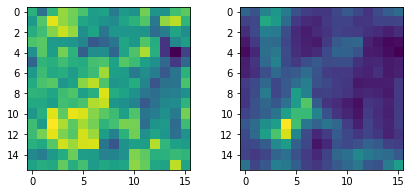

In [13]:
ic, fin = alldata[0]
fig, ax = plt.subplots(1, 2, figsize=(7, 3))
ax[0].imshow(ic.sum(axis=0))
ax[1].imshow(fin.sum(axis=0))
ic, fin = np.expand_dims(ic, 0), np.expand_dims(fin, 0)


In [14]:
tf.keras.backend.clear_session()


In [15]:
@tf.function
def pm(linear):
    state = lpt_init(linear, a0=0.1, order=1)
    final_state = nbody(state,  stages, nc)
    tfinal_field = cic_paint(tf.zeros_like(linear), final_state[0])
    return tfinal_field


@tf.function
def recon_prototype(linear, data, Rsm, anneal=True):
    """                                                                                                                                                   
    """
    print(linear)
#     linear = tf.reshape(linear, data.shape)
    final_field = pm(linear)

    residual = final_field - data #.astype(np.float32)
    base = residual

    if anneal :
        print("\nAdd annealing section to graph\n")
        Rsmsq = tf.multiply(Rsm*bs/nc, Rsm*bs/nc)
        smwts = tf.exp(tf.multiply(-kmesh**2, Rsmsq))
        basek = r2c3d(base, norm=nc**3)
        basek = tf.multiply(basek, tf.cast(smwts, tf.complex64))
        base = c2r3d(basek, norm=nc**3)

    chisq = tf.multiply(base, base)
    chisq = tf.reduce_sum(chisq)
    chisq = tf.multiply(chisq, 1/nc**3, name='chisq')

    #Prior                                                                                                                                                
    lineark = r2c3d(linear, norm=nc**3)
    priormesh = tf.square(tf.cast(tf.abs(lineark), tf.float32))
    prior = tf.reduce_sum(tf.multiply(priormesh, 1/priorwt))
    prior = tf.multiply(prior, 1/nc**3, name='prior')
    #                                                                                                                                                     
    loss = chisq + prior

    return loss


@tf.function
def val_and_grad(x, y, Rsm):
    print("val and grad : ", x.shape)
    with tf.GradientTape() as tape:
        tape.watch(x)
        loss = recon_prototype(x, y, Rsm)
    grad = tape.gradient(loss, x)
    return loss, grad

@tf.function
def grad(x, y, Rsm):
    with tf.GradientTape() as tape:
        tape.watch(x)
        loss = recon_prototype(x, y, Rsm)
    grad = tape.gradient(loss, [x])
    return grad


# Create an optimizer for Adam.                                                                                                                           
opt = tf.keras.optimizers.Adam(learning_rate=0.1)



In [16]:
# recon_prototype(linear, tf.constant(fin), tf.constant(0., dtype=tf.float32))


In [17]:
RRs = [0]
optimizer = 'adam'
niter = 100


#Loop it Reconstruction                                                                                                                                   
##Reconstruction                                                                                                                                          
x0 = np.random.normal(0, 1, nc**3).reshape(fin.shape).astype(np.float32)
linear = tf.Variable(name='linmesh', shape=(1, nc, nc, nc), dtype=tf.float32,
                         initial_value=x0, trainable=True)

for iR, RR in enumerate(RRs):

    for i in range(niter):
        grads = grad(linear, tf.constant(fin, dtype=tf.float32), tf.constant(RR, dtype=tf.float32))
#         recon_prototype(linear, tf.constant(fin), tf.constant(0., dtype=tf.float32))
        opt.apply_gradients(zip(grads, [linear]))
    minic = linear.numpy().reshape(fin.shape)
    
    x0 = minic
    
#     #                                                                                                                                                     
#     print('\nminimized\n')
#     minfin = pm(tf.constant(minic, dtype=tf.float32)).numpy()
#     dg.saveimfig("-R%d"%RR, [minic, minfin], [ic, fin], fpath+'')
#     dg.save2ptfig("-R%d"%RR, [minic, minfin], [ic, fin], fpath+'', bs)
#     ###                                                                                                                                                   
#     x0 = minic
# exit(0)




<tf.Variable 'linmesh:0' shape=(1, 16, 16, 16) dtype=float32>

Add annealing section to graph



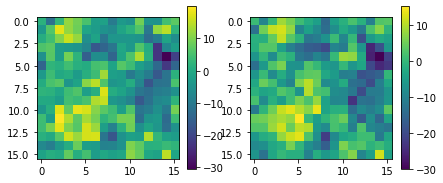

In [18]:
fig, ax = plt.subplots(1, 2, figsize=(7, 3))
im = ax[0].imshow(ic[0].sum(axis=0))
plt.colorbar(im, ax=ax[0])
im = ax[1].imshow(minic[0].sum(axis=0))
plt.colorbar(im, ax=ax[1])

#  RIM


In [14]:
# from recurrent_inference import ConvRIM3D
# from convolutional_recurrent import ConvLSTM3DCell


# @tf.function
# def likelihood_fn(inputs, predictions):
#   """ Evaluates the data likelihood function through Fast PM
#   """
#   final_field = pm(predictions[..., 0])
#   likelihood = tf.reduce_mean((final_field - inputs[...,0])**2/sigma**2, 
#                               axis=[1, 2, 3])
#   return likelihood

# @tf.function
# def gradient_fn(inputs, predictions):
#     """ Evaluates the data likelihood function through Fast PM
#     """
#     with tf.GradientTape() as tape:
#         tape.watch(x)
#         loss = likelihood_fn(x, y, Rsm)
#     grad = tape.gradient(loss, [x])
#     return grad
  

In [16]:
nb_samples = 100
batch_size = 16
time_max_rim = 30
time_max_gd = 60
nb_epochs = 2

size_train = 1000
size_test = 500

In [17]:
def simulate(x, A, sigma):
    return np.dot(A,x) + np.random.normal(0,sigma, (2,))

def generate_A():
    D = np.diag(np.random.choice([-1,1], (2,)) * np.random.uniform(0.25, 1, (2,)))
    theta = np.random.uniform(0,2*np.pi)
    P = np.array([[np.cos(theta), -np.sin(theta)], [np.sin(theta), np.cos(theta)]])
    return np.linalg.inv(P).dot(D).dot(P)

def loss(x, y, A):
    return 0.5 * x.T.dot(A.T).dot(A).dot(x) -  y.T.dot(A).dot(x)

def gradient(x, y, A):
    return A.T.dot(A.dot(x) - y)

In [18]:
A_train = np.array([generate_A() for i in range(size_train)]).astype(float32)
sigma_train = np.array([np.abs(np.random.uniform(0, 0.1)) for i in range(size_train)]).astype(float32)

X_train = np.array([np.random.uniform(-5, 5, (2,)) for i in range(size_train)]).astype(float32)
Y_train = np.array([simulate(x, A, sigma) for (x, A, sigma) in zip(X_train, A_train, sigma_train)]).astype(float32)
X_min_train = np.array([np.linalg.inv(A).dot(y) for (A,y) in zip(A_train,Y_train)]).astype(float32)
X0_train = np.array([x_min + np.random.uniform(-10,10,(2,)) for x_min in X_min_train]).astype(float32)

In [19]:
A_test = np.array([generate_A() for i in range(size_test)]).astype(float32)
sigma_test = np.array([np.abs(np.random.uniform(0, 1)) for i in range(size_test)]).astype(float32)

X_test = np.array([np.random.uniform(-5, 5, (2,)) for i in range(size_test)]).astype(float32)
Y_test = np.array([simulate(x, A, sigma) for (x, A, sigma) in zip(X_test, A_test, sigma_test)]).astype(float32)
X_min_test = np.array([np.linalg.inv(A).dot(y) for (A,y) in zip(A_test,Y_test)]).astype(float32)
X0_test = np.array([x_min + np.random.uniform(-10,10,(2,)) for x_min in X_min_test]).astype(float32)

# GD

In [140]:
lr = 0.1

list_xt_gd = []
for (x0, y, A) in zip(X0_test, Y_test, A_test):
    xt = x0.copy()
    list_xt = [x0]
    for t in range(1, time_max_gd):
        xt = xt - lr * gradient(xt, y, A)
        list_xt.append(xt)
    list_xt_gd.append(list_xt)
list_xt_gd = np.array(list_xt_gd)

In [141]:

extent_x, extent_y = 14, 6
xx_grid = np.array([np.linspace(x_min[0]-extent_x, x_min[0]+extent_x, 50) for x_min in X_min_test])
yy_grid = np.array([np.linspace(x_min[1]-extent_y, x_min[1]+extent_y, 50) for x_min in X_min_test])
XY_grid = np.array([np.meshgrid(xx, yy) for (xx,yy) in zip(xx_grid, yy_grid)])
X_grid = XY_grid[:,0,:,:]
Y_grid = XY_grid[:,1,:,:]
grid = np.concatenate([X_grid[:,:,:,np.newaxis], Y_grid[:,:,:,np.newaxis]], axis=3)
Z_grid = np.array([np.apply_along_axis(lambda x: loss(x, y, A), 2, g) for (y,A,g) in zip(Y_test, A_test, grid)])
colormap = np.array(plt.rcParams['axes.prop_cycle'].by_key()['color'])


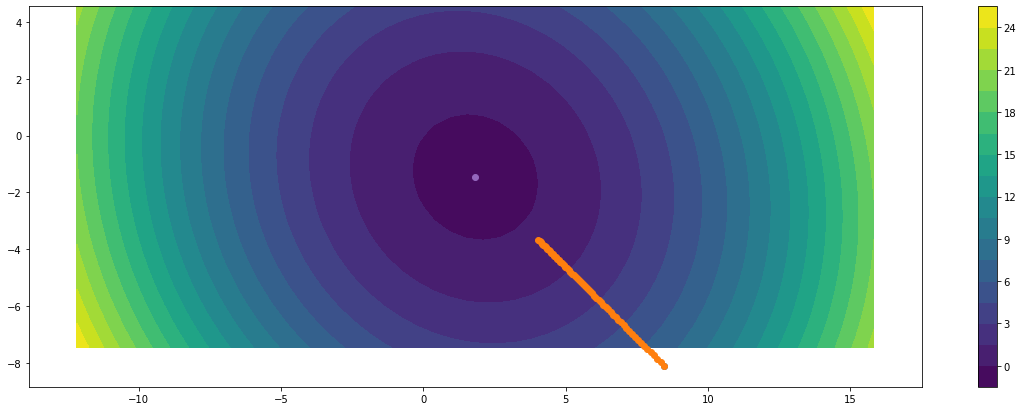

In [142]:
i_example = 37

plt.rcParams['figure.figsize'] = (20,7)
plt.axis('equal')

plt.contourf(X_grid[i_example], Y_grid[i_example], Z_grid[i_example], 20)
plt.colorbar()
plt.scatter(X_min_test[i_example][0], X_min_test[i_example][1], c=colormap[4])
plt.scatter(X0_test[i_example][0], X0_test[i_example][1])

plt.plot(list_xt_gd[i_example,:,0], list_xt_gd[i_example,:,1], color=colormap[1])
plt.scatter(list_xt_gd[i_example,:,0], list_xt_gd[i_example,:,1], c=colormap[1])

# Code RIM

In [151]:
del rim

In [21]:
from recurrent_inference import rim


In [24]:
output_size = 4
cell = LSTMCell(output_size)
cell.build([None, 4])
output_layer = Dense(2, input_shape=(None, output_size))

In [25]:
bb = 10
niter = 10

xx, yy = X_train[:bb].astype(float32), Y_train[:bb].astype(float32)
A = A_train[0]
idx = np.random.randint(0, X_train.shape[0], 100)
xx, yy = X_train[idx].astype(float32), Y_train[idx].astype(float32)
A = A_train[0]

# states = [np.zeros(shape=(1, 1, output_size)).astype(float32), 
#           np.zeros(shape=(1, 1, output_size)).astype(float32)]
states = tf.constant(np.zeros(shape=(2, idx.size,  output_size)).astype(float32))
states = [tf.Variable(states[0]), tf.Variable(states[1])]
out = cell(tf.constant(tf.concat([xx, xx*2], axis=-1)), states)

In [28]:
output_layer(out[0])

<tf.Tensor: shape=(100, 2), dtype=float32, numpy=
array([[-1.37498721e-01,  2.81694345e-02],
       [-2.44384054e-02, -4.16564830e-02],
       [ 4.04973887e-02, -1.88254043e-02],
       [-3.85697410e-02, -2.62307048e-01],
       [ 2.53128409e-02, -2.93517768e-01],
       [-2.40296185e-01,  6.48814142e-02],
       [-3.98097113e-02, -4.26629670e-02],
       [-8.82571936e-02, -1.70007218e-02],
       [-1.87881202e-01,  1.25448078e-01],
       [-5.41197546e-02, -1.13439169e-02],
       [-1.63380131e-01,  9.89981368e-02],
       [-2.25258082e-01,  1.73349053e-01],
       [ 5.92088215e-02, -1.91335857e-01],
       [-3.12737942e-01,  7.48532861e-02],
       [-1.66886821e-01,  5.17765544e-02],
       [-9.73514915e-02,  1.58910844e-02],
       [-2.38289550e-01,  4.61638123e-02],
       [-2.15640082e-03, -2.85922587e-01],
       [-2.67750889e-01,  1.07649691e-01],
       [-2.55137861e-01,  2.34358281e-01],
       [-1.53615683e-01,  9.02757794e-02],
       [-9.44534913e-02,  5.62445074e-02],
    

In [24]:
# idx = np.random.randint(0, X_train.shape[0], 100)
# xx, yy, AA = X_train[idx], Y_train[idx], A_train[idx]


# def test(x, A):
#     y = [x[i].dot(A[i]) for i in range(x.shape[0])]
#     return np.array(y)

# def test2(x, A):
#     y = [tf.matmul(x[i], A[i]) for i in range(x.shape[0])]
#     return y


# a = test2(tf.constant(xx), tf.constant(AA)).numpy()
# b = test(xx, AA)
# b.shape

In [144]:
# @tf.function
# def tf_loss3(x, y, A):
#     print('loss')
#     l = x.shape[1]
#     n = tf.constant(x.shape[0])
#     i = 0
#     term1 = tf.TensorArray(tf.float32, size=n)
#     term2 = tf.TensorArray(tf.float32, size=n)
#     x_t, y_t = tf.expand_dims(x, 1), tf.expand_dims(y, 1)
#     while tf.less(i, n):
#         term1 = term1.write(i, 0.5 * tf.matmul(x_t[i], tf.matmul(tf.transpose(A[i]), tf.matmul(A[i], tf.transpose(x_t[i]))))) 
#         term2 = term2.write(i,  - tf.matmul(y_t[i], tf.matmul(A[i], tf.transpose(x_t[i]))))
#         i = i+1
#     return tf.reduce_sum(term1.stack() + term2.stack())


# @tf.function
# def tf_loss2(x, y, A):
#     print('loss')
#     x_t, y_t = tf.expand_dims(x, 1), tf.expand_dims(y, 1)
# #     term1 = tf.map_fn(lambda a: 0.5 * tf.matmul(a[0], tf.matmul(tf.transpose(a[1]), tf.matmul(a[1], tf.transpose(a[0])))),
# #                       (x_t, A), dtype=tf.float32, parallel_iterations=20)
# #     term2 = tf.map_fn(lambda a: - tf.matmul(a[1], tf.matmul(a[2], tf.transpose(a[0]))), 
# #                       (x_t, y_t, A), dtype=tf.float32, parallel_iterations=20)
#     term1 = tf.vectorized_map(lambda a: 0.5 * tf.matmul(a[0], tf.matmul(tf.transpose(a[1]), tf.matmul(a[1], tf.transpose(a[0])))),
#                       (x_t, A))
#     term2 = tf.vectorized_map(lambda a: - tf.matmul(a[1], tf.matmul(a[2], tf.transpose(a[0]))), 
#                       (x_t, y_t, A))
#     return tf.reduce_sum(term1 + term2)


# @tf.function
# def tf_loss(x, y, A):
#     print('loss')
#     n = tf.constant(x.shape[0])
#     i = 0
#     loss = 0.
#     x_t, y_t = tf.expand_dims(x, 1), tf.expand_dims(y, 1)
#     while tf.less(i, n):
#         t1 =  tf.reduce_sum(0.5 * tf.matmul(x_t[i], tf.matmul(tf.transpose(A[i]), tf.matmul(A[i], tf.transpose(x_t[i])))))
#         t2 =  - tf.reduce_sum(tf.matmul(y_t[i], tf.matmul(A[i], tf.transpose(x_t[i]))))
#         loss = loss + t1 + t2
#         i = i+1
#     return loss

# idx = np.random.randint(0, 1000, 32)
# xinit, xx, yy = X0_train[idx].astype(float32), X_train[idx].astype(float32), Y_train[idx].astype(float32)
# A =  A_train[idx].astype(float32)
# a = tf_loss(tf.constant(xx), tf.constant(yy),tf.constant(A))
# b = tf_loss2(tf.constant(xx), tf.constant(yy),tf.constant(A))
# c = tf_loss3(tf.constant(xx), tf.constant(yy),tf.constant(A))
# a, b, c

## %timeit tf_loss(tf.constant(xx), tf.constant(yy),tf.constant(A))
## %timeit tf_loss2(tf.constant(xx), tf.constant(yy),tf.constant(A))
## %timeit tf_loss3(tf.constant(xx), tf.constant(yy),tf.constant(A))

In [191]:


@tf.function
def tf_fwdmodel(x, A):
    return tf.matmul(x, A)

# @tf.function
# def tf_loss(x, y, A):
#     term1 = 0.5 * tf.matmul(x, tf.matmul(tf.transpose(A), tf.matmul(A, tf.transpose(x)))) 
#     term2 = - tf.matmul(y, tf.matmul(A, tf.transpose(x)))
#     return term2 + term2

# @tf.function
# def tf_loss(x, y, A):
#     print('loss')
#     l = x.shape[1]
#     n = tf.constant(x.shape[0])
#     i = 0
#     term1 = tf.TensorArray(tf.float32, size=n)
#     term2 = tf.TensorArray(tf.float32, size=n)
#     while tf.less(i, n):
#         x_t, y_t = tf.expand_dims(x[i], 0), tf.expand_dims(y[i], 0)
#         term1 = term1.write(i, 0.5 * tf.matmul(x_t, tf.matmul(tf.transpose(A[i]), tf.matmul(A[i], tf.transpose(x_t))))) 
#         term2 = term2.write(i,  - tf.matmul(y_t, tf.matmul(A[i], tf.transpose(x_t))))
#         i = i+1
#     return tf.reduce_sum(term1.stack() + term2.stack())

@tf.function(
    input_signature=[tf.TensorSpec(shape=(None, 2), dtype=tf.float32), 
                    tf.TensorSpec(shape=(None, 2), dtype=tf.float32), 
                    tf.TensorSpec(shape=(None, 2, 2), dtype=tf.float32)])
def tf_loss(x, y, A):
    print('loss')
    x_t, y_t = tf.expand_dims(x, 1), tf.expand_dims(y, 1)
    term1 = tf.vectorized_map(lambda a: 0.5 * tf.matmul(a[0], tf.matmul(tf.transpose(a[1]), tf.matmul(a[1], tf.transpose(a[0])))),
                      (x_t, A))
    term2 = tf.vectorized_map(lambda a: - tf.matmul(a[1], tf.matmul(a[2], tf.transpose(a[0]))), 
                      (x_t, y_t, A))
    return tf.reduce_sum(term1 + term2)


@tf.function
def grad(x, y, A):
    print('grad')
    with tf.GradientTape() as tape:
        tape.watch(x)
        loss = tf_loss(x, y, A)
    grad = tape.gradient(loss, x)
    return grad



@tf.function
def augmented_step_full(x, states, y, A):
    print('graph')
    gradient = grad(x, y, A)
    inp = tf.concat([y, gradient], axis=-1)
    return cell(inp, states)                        

@tf.function
def augmented_step(x, states):
    print('aug step')
    gradient = grad(x, yy, A)
    xconcat = tf.concat([x, gradient], axis=-1)
    return cell(xconcat, states)                        


@tf.function
def tf_fwdrim(x, y, A, initstates=None):
    print('tf_fwdrim')
    if initstates is None: 
        initstates = [states[0]*0, states[1]*0]
    step = lambda x, states: augmented_step_full(x, states, 
                                              tf.constant(y), 
                                              tf.constant(A))
    return step(tf.constant(y), initstates)
    out = rim(step, tf.constant(y), initstates, 10)
    return out


# @tf.function
# def tf_fwdrim(x, y, A, initstates=None):
    
#     if initstates is None: 
#         initstates = [tf.constant(yy*0), tf.constant(yy*0)]
        
#     step = lambda x, states: augmented_step_full(x, states, 
#                                               tf.constant(yy*float32(np.random.normal(0, 1, 1))), 
#                                               tf.constant(A*float32(np.random.normal(0, 1, 1))))
# #     def step(x, states):
# #         print('graph')
# #         gradient = grad(x, tf.constant(y), tf.constant(A))
# #         inp = tf.concat([y, gradient], axis=-1)
# #         return cell(inp, states)                        
# #     return step(tf.constant(y), initstates)
#     out = rim(step, tf.constant(y), initstates)
# #     out = rim(augmented_step, tf.constant(y), initstates)
#     return out


@tf.function
def tf_fwdrim_loop(x, y, A, initstates=None):
    print('tf_fwdrim_loop')    
    if initstates is None: 
        initstates = [y*0., y*0.]
        
    step = lambda x, states: augmented_step_full(x, states, 
#                                               tf.constant(yy*(np.random.normal(0, 1, 1))), 
#                                               tf.constant(A*(np.random.normal(0, 1, 1))))
                                              y, A)

    outputs_ta = tf.TensorArray(size=niter, dtype=tf.float32)
    states_ta = tf.TensorArray(size=niter, dtype=tf.float32)

    def body(i, output_ta, states, state_ta):    
        new_output, new_state = step(y, states)
        output_ta = output_ta.write(i, new_output)
        state_ta = state_ta.write(i, new_state)
        return i +1 , output_ta, new_state, state_ta
    
    def cond(i, outputs_ta, states, state_ta):
        return i < niter

    final_output = tf.while_loop(
        cond,
        body,
        loop_vars=[
            0, outputs_ta, initstates, states_ta
        ],
        )
    
    return final_output[1].stack(), final_output[3].stack()


@tf.function
def tf_fwdrim_loop2(x, y, A, initstates=None):
    print('tf_fwdrim_loop2')
    if initstates is None: 
        initstates = [y*0., y*0.]
        
    outputs_ta = tf.TensorArray(size=niter, dtype=tf.float32)
    states_ta = tf.TensorArray(size=niter, dtype=tf.float32)

    def body(i, output_ta, states, state_ta):  
        gradient = grad(x, y, A)
        xconcat = tf.concat([y, gradient], axis=-1)
        print(xconcat.shape, states[0].shape, states[1].shape)
        new_output, new_state = cell(xconcat, states)
        output_ta = output_ta.write(i, new_output)
        state_ta = state_ta.write(i, new_state)
        return i +1 , output_ta, new_state, state_ta
    
    i = tf.constant(0, dtype=tf.int32)
    curr_state = initstates
    while tf.less(i, tf.constant(niter)):
        i, outputs_ta, curr_state, states_ta =  body(i, outputs_ta, curr_state, states_ta)
    
    return outputs_ta.stack(), states_ta.stack()


In [146]:
# tf_fwdrim(tf.constant(X_train[idx], Y_train[idx], A_train[idx]))
idx = np.random.randint(0, X_train.shape[0], 100)
xx, yy, A = X_train[idx].astype(float32), Y_train[idx].astype(float32), A_train[idx].astype(float32)
out = tf_fwdrim_loop2(tf.constant(X_train[idx]), tf.constant(Y_train[idx]), tf.constant(A_train[idx]))
out[0];
# for i in range(100):
#     out = tf_fwdrim_loop(tf.constant(X_train[idx]), tf.constant(Y_train[idx]), tf.constant(A_train[0]))


tf_fwdrim_loop2
grad
loss
(100, 4) (100, 2) (100, 2)


In [147]:
# for i in range(20):
#     augmented_step(tf.constant(yy), [tf.constant(yy)*0, tf.constant(yy)*0])    
    
# for i in range(30):
#     rim(augmented_step, tf.constant(yy), [tf.constant(yy)*np.random.randint(1), 
#                                           tf.constant(yy)**np.random.randint(1)]);


aug step


In [89]:
# for i in range(10):
#     tf_fwdrim(tf.constant(X_train[idx]), tf.constant(Y_train[idx]), tf.constant(A_train[0]))

# %%timeit 

# for i in range(100):
#     lstep = lambda x, states: augmented_step_full(x, states, 
#                                               tf.constant(yy*float32(np.random.normal(0, 1, 1))), 
#                                               tf.constant(A*float32(np.random.normal(0, 1, 1))))
#     out = rim(lstep, tf.constant(yy), states, 5)


In [214]:
class myRIM(tf.keras.Model):

    def __init__(self, cell, niter):
        super(myRIM, self).__init__()
        self.cell = cell
        self.niter = niter

            
    def call(self, x_init, y, grad_fn, grad_args, initstates = None, return_steps=False):
        
        outputs_ta = tf.TensorArray(size=self.niter+1, dtype=tf.float32)
        states_ta = tf.TensorArray(size=self.niter+1, dtype=tf.float32)
        
        if initstates is None: 
            initstates = [x_init, x_init*0.]
    
#         def body(i, output_ta, states, state_ta):  
#             gradient = grad_fn(states[0], y, *grad_args)
#             cell_state_concat = tf.concat([y, gradient], axis=-1)
#             new_output, new_state = self.cell(cell_state_concat, states)
#             output_ta = output_ta.write(i, new_output)
#             state_ta = state_ta.write(i, new_state)
#             return i +1 , output_ta, new_state, state_ta

#         def cond(i, outputs_ta, states, state_ta):
#             return i < niter
#         final_output = tf.while_loop(
#             cond, body, loop_vars=[0, self.outputs_ta, initstates, self.states_ta])
#         return final_output[1].stack(), final_output[3].stack()

    
        i = tf.constant(0, dtype=tf.int32)
        curr_state = initstates
        curr_pos = x_init
        
        def body(i, pos, states):  
            gradient = grad_fn(pos, y, *grad_args)
            cell_state_concat = tf.concat([y, gradient], axis=-1)
            new_pos, new_state = self.cell(cell_state_concat, states)
            return i +1 , new_pos, new_state
        
        while tf.less(i, tf.constant(self.niter)):
            outputs_ta = outputs_ta.write(i, curr_pos)
            states_ta = states_ta.write(i, curr_state)
            i, curr_pos, curr_state =  body(i, curr_pos, curr_state)
        outputs_ta = outputs_ta.write(i, curr_pos)
        states_ta = states_ta.write(i, curr_state)

        return outputs_ta.stack(), states_ta.stack()


In [215]:
cell = LSTMCell(2)
cell.build(input_shape=[None, 4])
testrim = myRIM(cell, niter=10)


idx = np.random.randint(0, X_train.shape[0], 10)
xinit, xx, yy, A = X0_train[idx].astype(float32), X_train[idx].astype(float32), Y_train[idx].astype(float32), A_train[idx]
out, states = testrim(x_init=tf.constant(xx), y=tf.constant(yy), grad_fn=grad, grad_args=[tf.constant(A)])



In [216]:
# testcell = LSTMCell(2)
# xinp = tf.concat([tf.constant(yy), tf.constant(xx)], axis=-1)
# teststates = [tf.constant(yy)*0, tf.constant(yy)*0]
# testcell(xinp, teststates)

In [279]:
# Create an optimizer for Adam.                                                                                                                           
opt = tf.keras.optimizers.Adam(learning_rate=10)


# @tf.function
def rim_train(x_true, x_init, y, A):
    with tf.GradientTape() as tape:
        x_pred, states = testrim(x_init, y, grad, [A])
        loss = tf.reduce_mean(tf.square((x_true- x_pred)))
    gradients = tape.gradient(loss, testrim.trainable_variables)
    opt.apply_gradients(zip(gradients, testrim.trainable_variables))
    return loss
    
    

In [271]:
# idx = np.random.randint(0, X_train.shape[0], 100)
# xinit, xx, yy = X0_train[idx].astype(float32), X_train[idx].astype(float32), Y_train[idx].astype(float32)

# with tf.GradientTape() as tape:
#     tape.watch(testrim.trainable_variables)
#     out, states = testrim(tf.constant(xinit),  tf.constant(yy), grad, [tf.constant(A)])
#     testloss = tf.reduce_sum((out - tf.constant(xx)**2))
# testgrads  = tape.gradient(testloss, testrim.trainable_variables)
    


In [280]:
# idx = np.random.randint(0, X_train.shape[0], 32)
# xx, yy, A = X_train[idx].astype(float32), Y_train[idx].astype(float32), A_train[idx]

losses = []
for i in range(100):
    idx = np.random.randint(0, X_train.shape[0], 32)
    xinit, xx, yy, A = X0_train[idx].astype(float32), X_train[idx].astype(float32), Y_train[idx].astype(float32), A_train[idx]
    losses.append(rim_train(tf.constant(xx), tf.constant(xinit), tf.constant(yy), tf.constant(A)).numpy())
#     testrim(tf.constant(xinit), tf.constant(yy), grad, [tf.constant(A)])
#     print(testrim.cell.kernel)    

[]

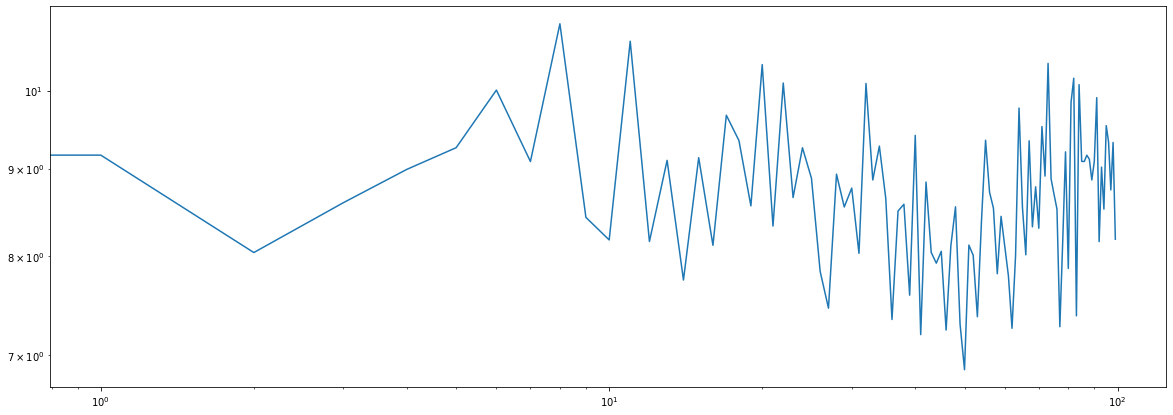

In [281]:
plt.plot(losses)
plt.loglog()

In [237]:
idx = np.random.randint(0, X_train.shape[0], 32)
xinit, xx, yy, A = X0_train[idx].astype(float32), X_train[idx].astype(float32), Y_train[idx].astype(float32), A_train[idx]
out = testrim(tf.constant(xinit), tf.constant(yy), grad, [tf.constant(A)])
pred = out[0].numpy()
cstate = out[1][:, 0]

In [239]:
np.unique(cstate/pred)

array([1.], dtype=float32)

In [246]:
np.array([np.dot(A[i], xx[i]) for i in range(xx.shape[0])]) /yy;

In [252]:
a = np.array([gradient(xx[i], yy[i], A[i]) for i in range(xx.shape[0])])
b = grad(tf.constant(xx), tf.constant(yy), tf.constant(A)).numpy()
a/b

array([[0.99999964, 1.0000015 ],
       [1.0000002 , 1.0000316 ],
       [1.000001  , 1.000003  ],
       [1.        , 0.9999999 ],
       [0.99997586, 1.0000067 ],
       [0.99999934, 1.0000075 ],
       [0.99999636, 1.0000004 ],
       [0.99999756, 1.0000031 ],
       [1.0000107 , 1.0000173 ],
       [1.0000012 , 0.99999964],
       [1.        , 0.9999971 ],
       [1.0000124 , 1.0000006 ],
       [0.99999887, 0.99999017],
       [0.99997056, 1.0000035 ],
       [0.99998957, 1.000179  ],
       [0.99999577, 1.0000002 ],
       [0.99999845, 0.9999934 ],
       [1.0000002 , 1.0000005 ],
       [1.0000018 , 0.99999994],
       [0.9999956 , 1.0000004 ],
       [1.0000001 , 0.99999917],
       [1.0000201 , 0.9999867 ],
       [1.0000008 , 0.9999913 ],
       [0.99999976, 0.9999996 ],
       [0.9999997 , 1.0000004 ],
       [0.99993557, 1.000004  ],
       [0.99998957, 1.000179  ],
       [0.99999964, 1.0000005 ],
       [1.0000006 , 0.9999999 ],
       [1.0000005 , 1.0000157 ],
       [1.